# Dimensionality reduction 2

__Week 2 - 4 May 2022__

After we have practised using some dimensionality reduction algorithms in basic mode, we will now turn our attention to arguably the most important part of the process - preprocessing and hyperparameter optimisation. Hopefully this will show how these steps can be crucial in producing the best possible representation of data in lower dimensions. Here, we will make use of a new astronomical dataset with the same algorithms as before (`PCA`, `t-SNE`, `UMAP`). We will end by returning to galaxies in COSMOS2015 and improving on the results from the previous session.

For a good overview of how `t-SNE` and `UMAP` work and compare, please see:\
https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668?gi=3ddf4de3641f.

---
### Data

Swift dataset - the dataset is light curves (intensity of light on a timeline) of gamma-ray bursts (GRB) coming from the far reaches of the universe. However, here we give the time-series of the bursts (signal as a function of time). In addition to the raw data, there are several derived properties (related to either time of the bursts or their intensity and wavelength):

* `T90_start` & `T90_end` - start and end times of the bursts of light.
* `fluence`
* `hardness`

---
### Exercise

You have now practiced reducing a dataset to a set of basis vectors via some projection or higher-dimenion embedding. The next step is to take an additional step of considering which data it is best to use in the first place and how to prepare it.

* Apply your favourite dimensionality reduction algorithm to: (1) properties, (2) raw observed data, (3) preprocessed observed data in the Swift dataset.

* Tweak hyperparameters of the algorithm - can you find an optimal combination?

* P.S. Why use only one of the algorithms at a time? Think about using one of these for preprocessing and the other for dimensionality reduction (eg., `PCA` + `t-SNE`).


---
* Authors:  Vadim Rusakov, Charles Steinhardt, Jackson Mann
* Email:  vadim.rusakov@nbi.ku.dk
* Date:   27th of April 2022

In [ ]:
!conda install -c conda-forge umap-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA

Load the raw data (light curves), as well as the properties (derived form raw data). 

Make sure to get rid of the `NaN` entries.

In [2]:
# loading data (light curves)
data = pd.read_pickle('datasets/swift_gamma_ray_bursts.zip')
    
# loading derived properties
props_full = pd.read_csv('datasets/SwiftProperties.csv')

# match & merge properties and raw data tables
df_merged = pd.merge(props_full, data, left_on='GRBname', right_index=True, how='inner')
mask = ~np.isnan(df_merged.iloc[:, 1:]).any(axis=1) # mask of NaNs
df_clean = df_merged.loc[mask] # clean of NaNs
X_data = df_merged.values[mask, 7:] # raw data
X_props = df_merged.values[mask, :7] # derived properties

print(f"the shape of the raw data set (nsamples, nfeatures): {X_data.shape}")
print(f"the shape of the properties data set (nsamples, nfeatures): {X_props.shape}")

the shape of the raw data set (nsamples, nfeatures): (1313, 51764)
the shape of the properties data set (nsamples, nfeatures): (1313, 7)


## Dataset 1. Gamma-ray bursts

1. Run your favourite algorithm (`t-SNE` or `UMAP`) on the bursts properties (`X_props`). Does it manage to split the samples into two types: eg., short and long bursts? $^1$

2. Can you explain the clumpiness of the reduction? Based on this, do derived prperties give a meaningful reduction? In not, can you argue why?


$^1$ Hint: short- or long-type of bursts separation is not obvious. Calculate the duration of bursts using the properties table and by subtracting `T90_start` from `T90_end`. Colour your scatter plots in reduced dimensions by duration. Try other properties as well.

In [3]:
# running t-SNE
tsne = TSNE(perplexity=15, n_iter=1500, init='random', verbose=2, 
            learning_rate='auto', method='barnes_hut', random_state=42)
y = tsne.fit_transform(X_props[:, 1:])

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1313 samples in 0.009s...
[t-SNE] Computed neighbors for 1313 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1313
[t-SNE] Computed conditional probabilities for sample 1313 / 1313
[t-SNE] Mean sigma: 0.921366
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 76.1883392, gradient norm = 0.0903375 (50 iterations in 0.561s)
[t-SNE] Iteration 100: error = 63.4980278, gradient norm = 0.0207527 (50 iterations in 0.483s)
[t-SNE] Iteration 150: error = 61.3067703, gradient norm = 0.0100300 (50 iterations in 0.515s)
[t-SNE] Iteration 200: error = 60.3032303, gradient norm = 0.0115388 (50 iterations in 0.442s)
[t-SNE] Iteration 250: error = 59.7827988, gradient norm = 0.0046991 (50 iterations in 0.390s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.782799
[t-SNE] Iteration 300: error = 1.1487199, gradient norm = 0.0022268 (50 iterations in 0.376s)

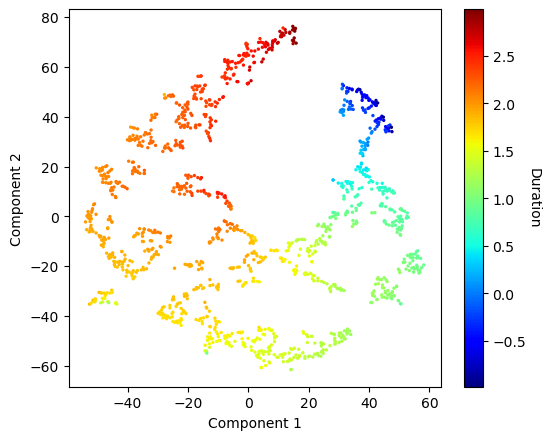

In [4]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

duration = np.log10(df_clean['T90_end'] - df_clean['T90_start'])

sc = ax.scatter(y[:, 0], y[:, 1], s=2.0, c=duration, cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Duration', rotation=270, labelpad=10)
plt.show()

Reapeat with `UMAP`:

In [5]:
map = umap.UMAP(n_components=2, n_neighbors=50, random_state=42)
y = map.fit_transform(X_props[:, 1:])

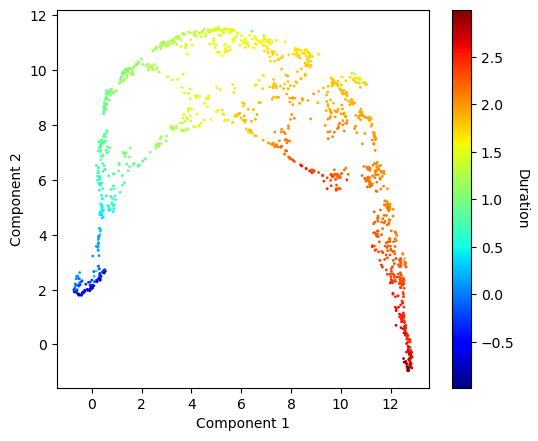

In [6]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y[:, 0], y[:, 1], s=1.0, c=duration,  cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Duration', rotation=270, labelpad=10)
plt.show()

As we can see from above, the two-dimensional maps look meaningful, when coloured by their properties (eg., you can see a gradient in terms of some of these properties).

Also, we don't get separate classes of objects, but rather a continuum. We don't have labels for these data, which means that there may well not be any classes, but before we can conclude that, we can still do a certian amount of data preparation.

Finally, observe the clumpiness above and compare this with the map you will see below - how do they compare?

3. Now train the algorithm with the raw data `X_data`. Are you able to make cleaner classifications using the projections in the space learnt by the algorithms? If not, do you have some ideas for how to improve this?

In [7]:
map = umap.UMAP(n_components=2, n_neighbors=50, random_state=42)
y = map.fit_transform(X_data)

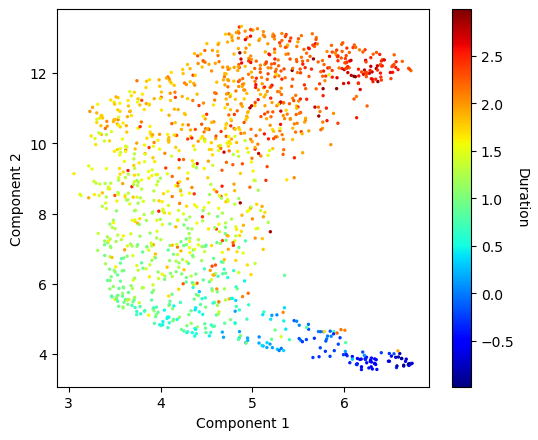

In [8]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
duration = np.log10(df_clean['T90_end'] - df_clean['T90_start'])

sc = ax.scatter(y[:, 0], y[:, 1], s=2.0, c=duration, cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Duration', rotation=270, labelpad=10)
plt.show()

The map obtained above using the raw data is certianly less clumpier than the one obtained using the derived properties before. As if the objects in the new 2D-space have more freedom when described in terms of the raw data.

This makes sense, because the properties are some sort of linear/non-linear combination of the raw data. In addition, it is always the possible that in the process of deriving the properties some data may be discarded. It means that the properties may carry less information than the raw data, or, in the best case, as mush as the raw data. Therefore it is always best to start with the raw data in dimension reduction.

4. Suggestion: try converting the time-series `X_data` to frequency space by taking a Fourier transform. Repeat the exercise. Does this help to create a cleaner representation in the reduced space? What physical meaning does the separation imply? (for eg., in terms of the burst duration property).

**Note**: application of the Fourier transform is not intuituve here and specific of the data at hand. It does not mean that you should use this as a standard go-to approach in any case. Here we have time-series data (signal as a function of time), where the signal was recorded with a telescope. The starting times of the recordings of different events were not always aligned. Therefore the Fourier transform is helpful here to use the frequency information about the signals, rather than the biased time-series.

In [9]:
# taking Fast Fourier Transform
X_data_fft = abs(np.fft.rfft(X_data)) # take modulus to convert to float from complex data type
mask_fft = ~np.isnan(X_data_fft[:, 1:]).any(axis=1) # NaNs
X_data_mod = X_data_fft[mask_fft] # mask out NaNs

In [10]:
# running t-SNE
tsne = TSNE(perplexity=15, n_iter=15000, init='random', verbose=2, 
            learning_rate='auto', method='barnes_hut', random_state=42)
y_tsne = tsne.fit_transform(X_data_mod)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1313 samples in 0.023s...
[t-SNE] Computed neighbors for 1313 samples in 0.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1313
[t-SNE] Computed conditional probabilities for sample 1313 / 1313
[t-SNE] Mean sigma: 10993906.026536
[t-SNE] Computed conditional probabilities in 0.044s
[t-SNE] Iteration 50: error = 76.6243591, gradient norm = 0.0268797 (50 iterations in 0.454s)
[t-SNE] Iteration 100: error = 69.5487976, gradient norm = 0.0081048 (50 iterations in 0.541s)
[t-SNE] Iteration 150: error = 69.2812958, gradient norm = 0.0010236 (50 iterations in 0.690s)
[t-SNE] Iteration 200: error = 69.2789383, gradient norm = 0.0002952 (50 iterations in 0.498s)
[t-SNE] Iteration 250: error = 69.2787704, gradient norm = 0.0004332 (50 iterations in 0.535s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.278770
[t-SNE] Iteration 300: error = 1.6274538, gradient norm = 0.0015276 (50 iterations in 

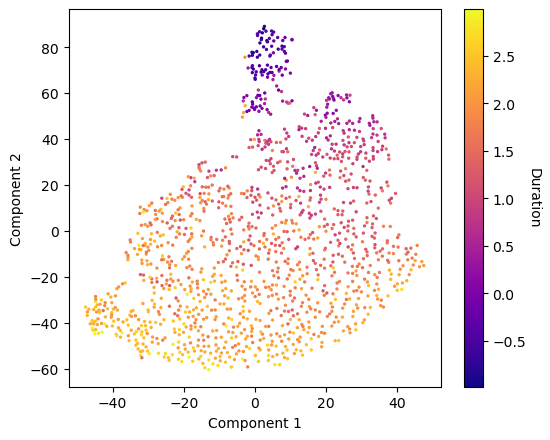

In [11]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
duration = np.log10(df_clean['T90_end'] - df_clean['T90_start'])
duration = duration.iloc[mask_fft]

sc = ax.scatter(y_tsne[:, 0], y_tsne[:, 1], s=2.0, c=duration, cmap='plasma')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Duration', rotation=270, labelpad=10)
plt.show()

And again, repeat with `UMAP`:

In [12]:
map = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, 
                random_state=42, set_op_mix_ratio=0.25)
y_umap = map.fit_transform(X_data_mod)

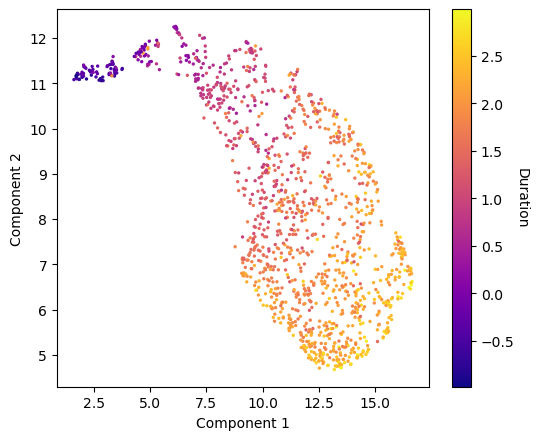

In [13]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
duration = np.log10(df_clean['T90_end'] - df_clean['T90_start'])
duration = duration.iloc[mask_fft]

sc = ax.scatter(y_umap[:, 0], y_umap[:, 1], s=2.0, c=duration, cmap='plasma')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Duration', rotation=270, labelpad=10)
plt.show()

Hey! After applying our transformation of the inputs, the resulting embeddings hint at the fact that we indeed have two almost distinct classes (with some intersection probably). When coloured by time `duration`, this suggests that the two classes have either short or long duration. That's very useful!

5. Try experimenting: the main parameter in `t-SNE` is `perplexity` - try using the values of `5, 10, 15, 20, 50`. The analogous parameter for `UMAP` is `n_neighbours`. Can you find a number that makes an optimal separation of bursts? How would this number have to change depending on the size of the dataset, eg. if you have **10x**, **100x** more samples?

    * Probably `perplexity=10-20` makes a good separation. To preserve the same structure in a dataset that has more samples, one would have to increase `perplexity`, as more data would fill the available space. Therefore, as a rule of thumb, one can take usually start with a `perplexity` of $\sqrt{n}$ for $n$ samples in the data (as a first guess).

6. Try changing the different options `method='exact'` $\left[ \mathcal{O}(n^2) \right]$ and `method='barnes_hut'` $\left[ \mathcal{O}(n \log{n}) \right]$. The complexity of the operations with the two is different: `barnes_hut` provides an approximate map, but with less time spent.

7. Try different value of the number of iterations (`n_iter`). Can you reach the point where the algorithm converges (be gentle to your computer)? Remember that you need to have at least `n_iter = 250`, as the algorithm requires those for calibration. If it takes too long to converge try taking a smaller sub-sample.

    * Setting `n_iters=15000`, gives enough time to converge on a solution. If it takes too long to converge, you can try to reduce the dimensionality of the data given to `t-SNE` or `UMAP` using `PCA`. `t-SNE` is the slowest of the two.

Ok, ones we have managed to obtain a useful embedding, how can we used it? 

First, we can assign labels to different clusters. Clustering can be done with a range of available algorithms. For comparison, see: \
https://scikit-learn.org/stable/modules/clustering.html.

Try using various options, like `k-Means` (will likely not succeed here, as the two clusters are not balanced). Here, we will use `DBSCAN`. It will assign all separate clusters a unique non-negative integer label (eg., $i=0,1,2,...$), while the noisy samples, if present, will be labelled as $i=-1$. Reference: [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN).

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=6.5, min_samples=15)
y_labels = dbscan.fit_predict(y_tsne)
print(f"unique class labels: {np.unique(y_labels)}")

unique class labels: [0 1]


To get the above clean clustering, one would have to balance the two parameters: `eps` & `min_samples`. The first defines the distance scale of the neighbourhood, while the second - the membership (number of neighbours). Combinations of the two can make `DBSCAN` sensitive to clusters on different scales.

After getting the clustering and assigning the labels to the red and blue clusters, we can investigate one of the properties for the both clusters (`duration`):

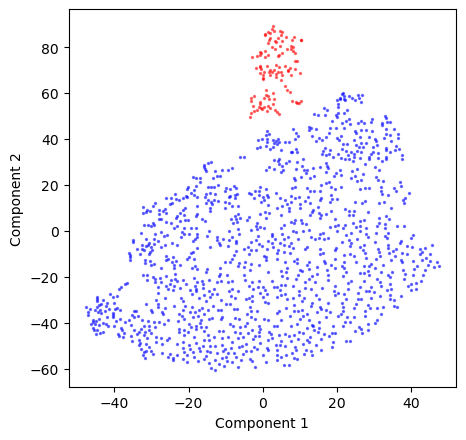

In [16]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
duration = np.log10(df_clean['T90_end'] - df_clean['T90_start'])
duration = duration.iloc[mask_fft]

a, b = np.unique(y_labels)
db0 = y_labels == a
db1 = y_labels == b
sc = ax.scatter(y_tsne[db0, 0], y_tsne[db0, 1], s=2.0, c='b', alpha=0.5)
sc = ax.scatter(y_tsne[db1, 0], y_tsne[db1, 1], s=2.0, c='r', alpha=0.5)
cbar.ax.set_ylabel('Duration', rotation=270, labelpad=10)
plt.show()

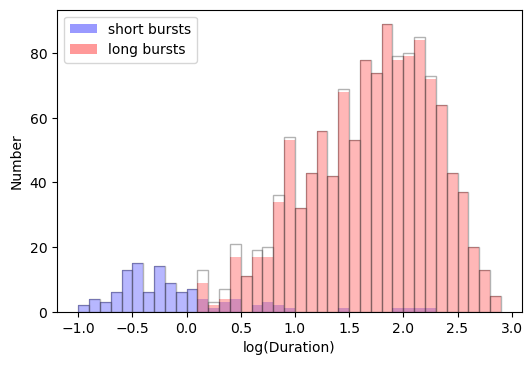

In [17]:
# bin two distributions of durations (defined by the above red-blue clusters)
bins = np.arange(-1, 3.0, 0.1) # duration bins
h0, x0 = np.histogram(duration[db0], bins=bins) # bin durations
h1, x1 = np.histogram(duration[db1], bins=bins)
h_tot, x_tot = np.histogram(duration, bins=bins)
x1mid = (x1[1:] + x1[:-1]) * 0.5 # get central poisitions of bins using the bin edges
x0mid = (x0[1:] + x0[:-1]) * 0.5
xtotmid = (x_tot[1:] + x_tot[:-1]) * 0.5

fig, ax = plt.subplots(1, subplot_kw={'xlabel': 'log(Duration)', 
                                      'ylabel': "Number"}, 
                       dpi=100) # plot the distributions
ax.bar(x1mid, h1, width=0.1, color='b', alpha=0.4, label='short bursts')
ax.bar(x0mid, h0, width=0.1, color='r', alpha=0.4, label='long bursts')
ax.bar(xtotmid, h_tot, width=0.1, color='w', alpha=0.3, edgecolor='k')
plt.legend()
plt.show()

There is a nice separation that confirms that the two classes have different distributions in `duration`. However, you can see that there are a few "short" outliers far inside the "long" distribution (i.e. the blue among the red at $1.5 < log(duration) < 2.0$). These could potentially be physically anomolous detections (i.e. something wrong with their raw data, maybe instrument effects or some biased preprocessing was actually done on those data).

To summarise, what we have done above is 

* We introduced a novel way of classifying objects that were previously not known to form distinct classes. 

* We used one of the physical properties of the objects to do that: `duration`. 

* This is a clear example of using dimension reduction in an **unsupervised** way. 

* Can you formulate the classes using other properties of the space bursts?

* If you are convinced that the classification is accurate, you could use this method to label the data and use it as a training set in a **supervised** setting. This means you could use these training features and labels to make predictions on new data in the future.

Isn't it great? 😊

As a bonus, the plot below shows an example of how you could classify new objects in the embedding where we have just labelled the objects. Here the new objects will be just a meshgrid sampling the full embedding space:

In [18]:
from sklearn.svm import SVC

# as one option among many, we could use a support vector machine (SVM)
# to split the embedding into sub-spaces for classification
# first, create a meshgrid of the parameter space 
# (in the coordinates of the t-SNE embedding)
xs = np.arange(y_tsne[:, 0].min(), y_tsne[:, 0].max()+1, 1)
ys = np.arange(y_tsne[:, 1].min(), y_tsne[:, 1].max()+1, 1)
xx, yy = np.meshgrid(xs, ys)
xy = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1) # reshape from mesh into a [nsamples, 2] input for a classifier
n = len(xs) # number of points on a mesh side

# train an SVM and predict on a meshgrid
svc = SVC(kernel='poly', probability=True)
svc.fit(y_tsne, y_labels)
y_mesh = svc.predict_proba(xy)
y_mesh = y_mesh.reshape(-1, n, 2) # reshape into a mesh again

After traing the SVM using our labelled training data, we can see how it would classify new objects within this whole 2D space. Note that the decision boundary here is **arbitrary** and depends on the kernel you choose, other classifier parameters and the training data (i.e. red and blue points). So keep that in mind and be careful.

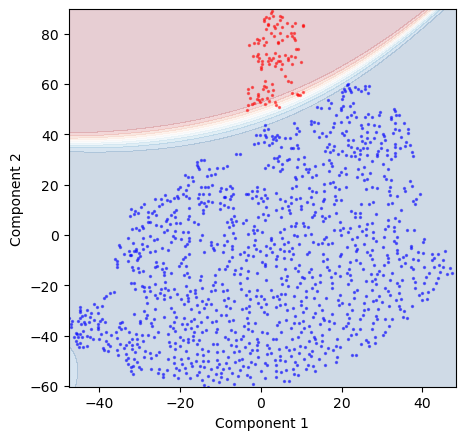

In [19]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
duration = np.log10(df_clean['T90_end'] - df_clean['T90_start'])
duration = duration.iloc[mask_fft]

a, b = np.unique(y_labels)
db0 = y_labels == a
db1 = y_labels == b
ax.contourf(xx, yy, y_mesh[:, :, 0], levels=np.arange(0,1.1,0.1), cmap='RdBu', alpha=0.2)
sc = ax.scatter(y_tsne[db0, 0], y_tsne[db0, 1], s=2.0, c='b', alpha=0.5)
sc = ax.scatter(y_tsne[db1, 0], y_tsne[db1, 1], s=2.0, c='r', alpha=0.5)
cbar.ax.set_ylabel('Duration', rotation=270, labelpad=10)
plt.show()

## Dataset 2. Back to COSMOS2015 (galaxies)

Now, repeat the experiment from the previous session with the galaxies dataset. This time think about preprocessing and hyperparameter optimisation and repeat the exercise. At the end try to classify galaxies as either `alive` or `dead`.

1. Recall that the linear `PCA` before was not capable of linearly separating two types of galaxies at all. In fact, the data you were given were not entirely ready. You need to preprocess them first. For this, take all fluxes and normalize them by one of the other fluxes. $^{1,2}$ Repeat the exercise. Do you get better separation?

$^1$ Hint: it turns out the star forming and dead galaxies are most different in the bluer bands (like `u_flux`).\
$^2$ Hint: plot distributions of features before preprocessing and compare with the same after.

In [20]:
# turn off warnings, no one needs them...
pd.options.mode.chained_assignment = None  # default='warn'

file = "datasets/cosmos2015.csv"
df = pd.read_csv(file, index_col=False)

# select a random sub-sample of the dataset
n = 10000
idxs = np.arange(df.shape[0])
idxs_rand = np.random.choice(idxs, size=n)
df_cut = df.iloc[idxs_rand] # dataframe
X = df.iloc[idxs_rand].values # array

flux_cols = list(df.columns[4:]) # flux column names
flux_idxs = np.argwhere(np.isin(df.columns, flux_cols)).flatten() # flux column indices

Plot feature distributions before their normalization:

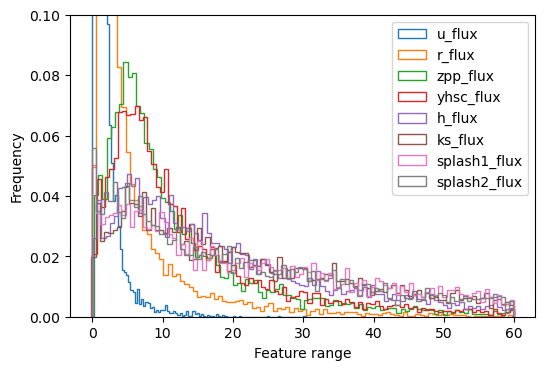

In [21]:
fig, ax = plt.subplots(1, subplot_kw={'xlabel': "Feature range", 
                                      'ylabel': "Frequency"}, 
                       dpi=100)
for i, col in enumerate(flux_cols):
    vec = X[:, flux_idxs[i]]
    vec = vec[(vec > (-10)) & (vec < 60)]
    ax.hist(vec, bins=100, label=col, density=True, histtype='step')
ax.set_ylim(0, 0.1)
plt.legend()
plt.show()

Normalize the data:

In [22]:
# normalize fluxes 
norm_flux = df_cut.loc[:, 'u_flux'].values
X_trans = np.copy(X)
for col in flux_idxs:
    X_trans[:, col] = X_trans[:, col] / norm_flux

The result of the normalization is below. The distributions are a little more closely spaced and span the similar numerical ranges.

You can experiment here and investigate other ways of transforming these feature distributions. For reference, see: https://scikit-learn.org/stable/modules/preprocessing.html.

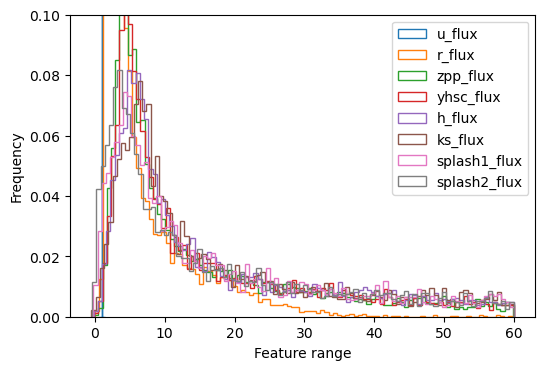

In [23]:
fig, ax = plt.subplots(1, subplot_kw={'xlabel': "Feature range", 
                                      'ylabel': "Frequency"}, 
                       dpi=100)
for i, col in enumerate(flux_cols):
    vec = X_trans[:, flux_idxs[i]]
    vec = vec[(vec > (-10)) & (vec < 60)]
    ax.hist(vec, bins=100, label=col, density=True, histtype='step')
ax.set_ylim(0, 0.1)
plt.legend()
plt.show()

We can try `PCA` again (this time on the preprocessed data):

In [24]:
pca = PCA(n_components=2, svd_solver='full')
y_pcs = pca.fit_transform(X_trans[:, flux_idxs]) # train only on fluxes (raw observed data)

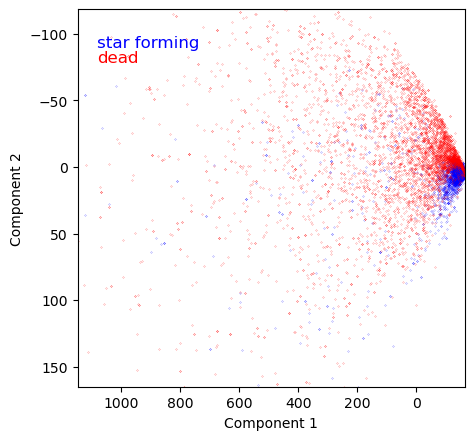

In [25]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1)

ax.scatter(y_pcs[is_sf, 0], y_pcs[is_sf, 1], s=0.02, c='b')
ax.scatter(y_pcs[~is_sf, 0], y_pcs[~is_sf, 1], s=0.02, c='r')
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()

The above is somewhat better than a mixed blob we obtained in the previous session.

### t-SNE

In [26]:
tsne = TSNE(n_components=2, init='random', method='barnes_hut', 
            random_state=42, perplexity=15, n_iter=500, verbose=2)
y_tsne = tsne.fit_transform(X_trans[:, flux_idxs])

/Users/Vadim/miniconda3/envs/appml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.853851
[t-SNE] Computed conditional probabilities in 0.137s
[t-SNE] Iteration 50: error = 102.8070297, gradient norm = 0.0276500 (50 iterations in 2.790s)
[t-SNE] I

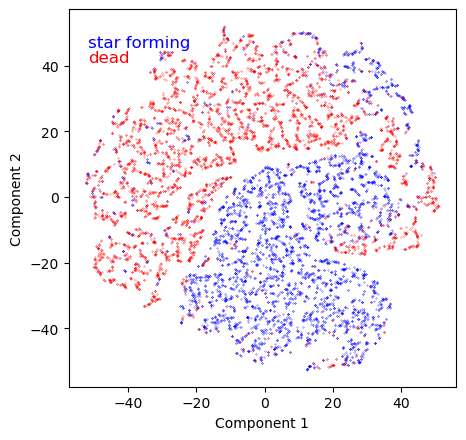

In [27]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1)

ax.scatter(y_tsne[is_sf, 0], y_tsne[is_sf, 1], s=0.05, c='b')
ax.scatter(y_tsne[~is_sf, 0], y_tsne[~is_sf, 1], s=0.05, c='r')
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()

### UMAP

In [28]:
map = umap.UMAP(n_components=2, n_neighbors=50, random_state=42)
y_umap = map.fit_transform(X_trans[:, flux_idxs])

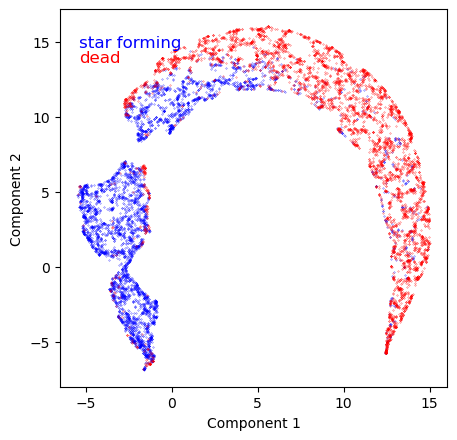

In [29]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1)

ax.scatter(y_umap[is_sf, 0], y_umap[is_sf, 1], s=0.05, c='b')
ax.scatter(y_umap[~is_sf, 0], y_umap[~is_sf, 1], s=0.05, c='r')
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()

2. Even with a high degree of separation, whether star forming or dead, there is a continuum of galaxies with varying masses and rates of star formation. Therefore, do you ever expect there to be discrete islands of galaxies when you reduce the dimensions? $^1$

    * we can attempt to reduce the data to receive those islands. But, likely, for this we have to remove a bias in these data: `redshift`. The issue here is similar to the gamma-ray burst dataset (the spectra are not aligned in the wavelength axis and therefore, as there is a distribution of redshifts, the spectra will always form some sort of continuum).

$^1$ Hint: produce scatter plots in the reduced space and colour the points by different galaxy properties.

We have just tried using clustering with the above dataset. How well did the dimension reduction manage to split the data into separate meaningful clusters? Visually, there is a meaningfull separation, but no separate clusters. If we didn't have the labels, the embeddings above would not be useful (eg., imaging that all points above are all black - you wouldn't be able to see different clusters). But here we can show an example of how we can cheat when we do have the labels (i.e. in a **supervised** task). The examples of how we can score the performance in such tasks are presented below:

**Example 1. Let the neighbours vote.**

In [30]:
def get_prob(ycoords, ylabels, radius=1):
    """
    This function gives a probability for an object to be 
    an 'active' galaxy or 'dead'. It takes an object, 
    locates all its neighbours withing a specified radius
    and calculates the probability as the fraction: 
        prob = N_active / (N_active + N_dead)
    
    Parameters: 
    ----------
    ycoords - coordinates in an embedding y: [component1, component2].
    ylabels - labels of the objects: 1 - galaxy is alive, 0 - dead.
    radius - to define neighbours around every point.
    """
    probs = np.empty(shape=(len(ycoords))) # to store probabilities
    for i, dot in enumerate(ycoords):
        # check which points are in the neighbourhood of the current point
        dist = np.sqrt( (ycoords[:, 0] - dot[0])**2 + (ycoords[:, 1] - dot[1])**2 )
        is_in_circle = dist < radius
        
        # within the circle divide the number of living galaxies 
        # by the number of dead galaxies to calculate the probability
        # of being a living galaxy
        prob = ylabels[is_in_circle].sum() / len(ylabels[is_in_circle])
        probs[i] = prob
    return probs

ylabels = is_sf.astype(int) # labels: 1 - galaxy is alive, 0 - dead.

# t-SNE probabilities
prob_alive_tsne = get_prob(y_tsne, ylabels, radius=5)

# UMAP probabilities
prob_alive_umap = get_prob(y_umap, ylabels, radius=3)

The distribution of the probabilities looks like:

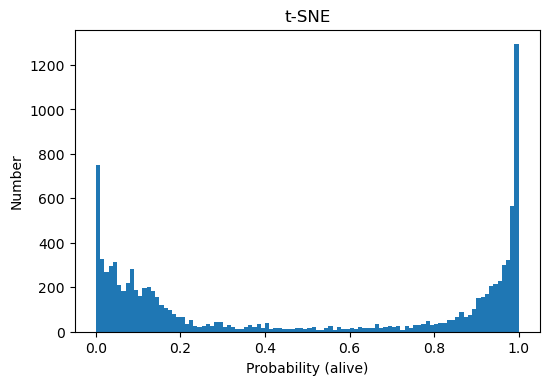

In [31]:
fig, ax = plt.subplots(1, subplot_kw={'xlabel': "Probability (alive)", 
                                      'ylabel': "Number"}, 
                       dpi=100)
ax.hist(prob_alive_tsne, bins=100)
ax.set_title('t-SNE')
plt.show()

... and for `UMAP`:

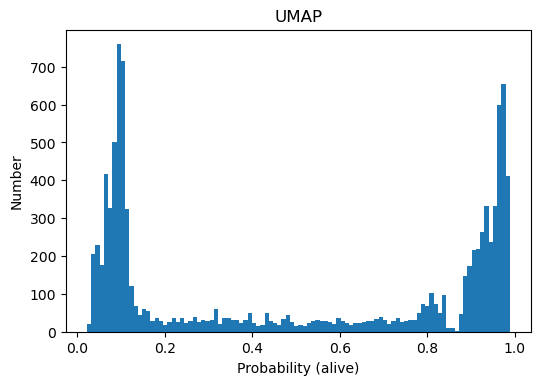

In [32]:
fig, ax = plt.subplots(1, subplot_kw={'xlabel': "Probability (alive)", 
                                      'ylabel': "Number"}, 
                       dpi=100)
ax.hist(prob_alive_umap, bins=100)
ax.set_title('UMAP')
plt.show()

We can also colour our embedding by the object probabilities:

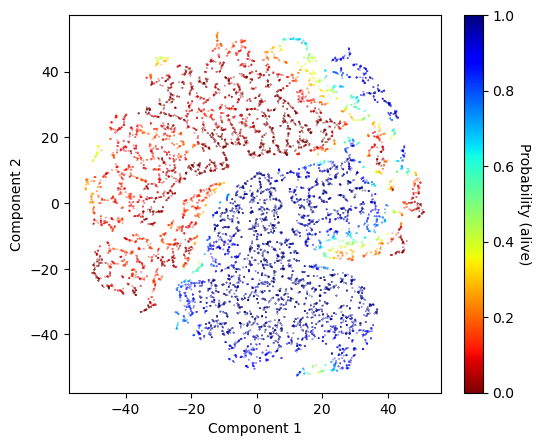

In [33]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y_tsne[:, 0], y_tsne[:, 1], s=0.05, c=prob_alive_tsne, cmap='jet_r')
cbar = plt.colorbar(sc)
cbar.set_label(label='Probability (alive)', rotation=270, labelpad=12)
cbar.set_ticks(np.arange(0, 1.1, 0.2))
plt.show()

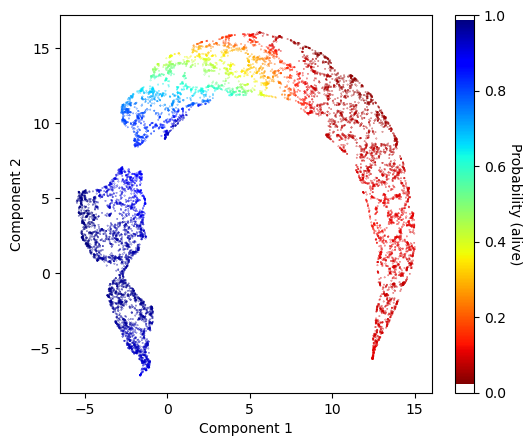

In [34]:
fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sc = ax.scatter(y_umap[:, 0], y_umap[:, 1], s=0.05, c=prob_alive_umap, cmap='jet_r')
cbar = plt.colorbar(sc)
cbar.set_label(label='Probability (alive)', rotation=270, labelpad=12)
cbar.set_ticks(np.arange(0, 1.1, 0.2))
plt.show()

We can also plot the **ROC curves** based on the above classification:

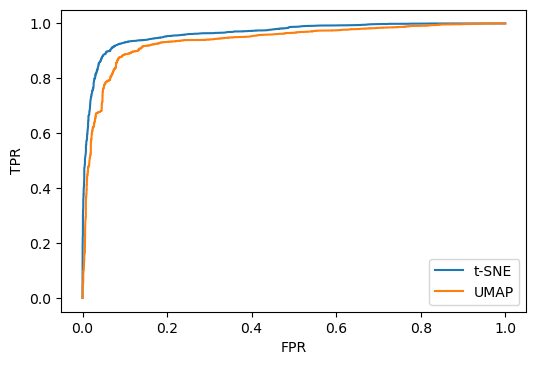

In [35]:
from sklearn.metrics import roc_curve

fpr_tsne, tpr_tsne, _ = roc_curve(ylabels, prob_alive_tsne)
fpr_umap, tpr_umap, _ = roc_curve(ylabels, prob_alive_umap)

fig, ax = plt.subplots(1, subplot_kw={'xlabel': "FPR", 
                                      'ylabel': "TPR"}, 
                       dpi=100)
ax.plot(fpr_tsne, tpr_tsne, label='t-SNE')
ax.plot(fpr_umap, tpr_umap, label='UMAP')
plt.legend()
plt.show()

## PCA + t-SNE

4. Try experimenting: can you combine `PCA` (or `kPCA`) and `t-SNE` as part of the preprocessing and training procedures? Note, this is not guaranteed to give better results, but could be worth exploring.

In [36]:
# preprocessing
kpca = KernelPCA(n_components=6, kernel='poly')
y_pcs = kpca.fit_transform(X_trans[:, flux_idxs])

In [37]:
# reducing dimensions to 2 components
map = TSNE(n_components=2, perplexity=15, n_iter=1000, 
           random_state=42, verbose=2)
y_comb = map.fit_transform(y_pcs)

/Users/Vadim/miniconda3/envs/appml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/Vadim/miniconda3/envs/appml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.385194
[t-SNE] Computed conditional probabilities in 0.182s
[t-SNE] Iteration 50: error = 101.6607361, gradient norm = 0.0281020 (50 iterations in 2.076s)
[t-SNE] I

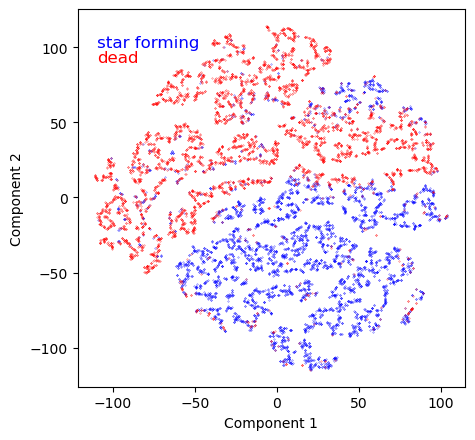

In [38]:
fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
is_sf = np.isin(df_cut.loc[:, 'is_star_forming'], 1)

ax.scatter(y_comb[is_sf, 0], y_comb[is_sf, 1], s=0.05, c='b')
ax.scatter(y_comb[~is_sf, 0], y_comb[~is_sf, 1], s=0.05, c='r')
ax.annotate("star forming", xy=(0.05, 0.9), xycoords="axes fraction", 
            color='b', fontsize=12)
ax.annotate("dead", xy=(0.05, 0.86), xycoords="axes fraction", 
            color='r', fontsize=12)
plt.show()